In [1]:
import numpy
import tqdm
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot
from joblib import dump, load
%matplotlib inline

In [2]:
# specify the dataset settings (a mixutre of gaussian)

pi = numpy.array([0.5, 0.5])
ita_0 = numpy.array([0.5, 0.5])
ita_1 = numpy.array([0.5, 0.5])
mu_0_0 = numpy.array([4.0]) 
mu_0_1 = numpy.array([-64.0]) 
mu_1_0 = numpy.array([-4.0])
mu_1_1 = numpy.array([72.0 ]) 
cov_0_0 = numpy.array([960.0])
cov_0_1 = numpy.array([1280.0])
cov_1_0 = numpy.array([980.0])
cov_1_1 = numpy.array([1024.0])

N_grid = 1024

In [3]:
# calculate densities of the predicted probabilities

N = int(1e6)
N_sim = int(128)
p_s = numpy.zeros(N_grid-1)
p_s_0 = numpy.zeros(N_grid-1)
p_s_1 = numpy.zeros(N_grid-1)
for i in tqdm.trange(0, N_sim):
    y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)

    x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
         scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
         scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
         scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

    x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
        x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1)

    y = numpy.vstack([y[:, 0] + y[:, 1],
                      y[:, 2] + y[:, 3]]).transpose()

    # p_x_y_sample = numpy.vstack([pi[0] * ita_0[0] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_0_0, cov=cov_0_0) +
    #                              pi[0] * ita_0[1] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_0_1, cov=cov_0_1),
    #                              pi[1] * ita_1[0] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_1_0, cov=cov_1_0) +
    #                              pi[1] * ita_1[1] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_1_1, cov=cov_1_1)])

    # p_x_sample =  numpy.sum(p_x_y_sample, axis=0)

    # s_sample = (p_x_y_sample / p_x_sample).transpose()

    s_sample = numpy.zeros((N, 2))
    
    s_sample[:, 1] = 1 / (1 + numpy.exp(-0.01 * x.ravel()))
    s_sample[:, 0] = 1 - s_sample[:, 1]

    p_s = p_s + numpy.histogram(s_sample[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_0 = p_s_0 + numpy.histogram(s_sample[y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_1 = p_s_1 + numpy.histogram(s_sample[y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    
p_s = p_s
p_s_0 = p_s_0
p_s_1 = p_s_1

100%|██████████| 128/128 [00:57<00:00,  2.24it/s]


In [4]:
# draw samples and calculate corresponding values

N = 10000
y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)
x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
    x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1)

y = numpy.vstack([y[:, 0] + y[:, 1],
                  y[:, 2] + y[:, 3]]).transpose()

s_sample = numpy.zeros((N, 2))

s_sample[:, 1] = 1 / (1 + numpy.exp(-0.01 * x.ravel()))
s_sample[:, 0] = 1 - s_sample[:, 1]

# p_x_y_sample = numpy.vstack([pi[0] * ita_0[0] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_0_0, cov=cov_0_0) +
#                              pi[0] * ita_0[1] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_0_1, cov=cov_0_1), 
#                              pi[1] * ita_1[0] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_1_0, cov=cov_1_0) +
#                              pi[1] * ita_1[1] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_1_1, cov=cov_1_1)])

# p_x_sample =  numpy.sum(p_x_y_sample, axis=0)

# s_sample = (p_x_y_sample / p_x_sample).transpose()

# s_sample[:, 1] = numpy.clip((s_sample[:, 1] - 0.5) * 0.5 + 0.5, 0, 1)
# s_sample[:, 0] = 1 - s_sample[:, 1]

In [5]:
# calculate related probabilities

p_x_y_hat = numpy.vstack([pi[0] * p_s_0.ravel(),
                          pi[1] * p_s_1.ravel()])

p_x_hat =  numpy.sum(p_x_y_hat, axis=0)

p_y_hat = p_x_y_hat / p_x_hat

ipykernel_launcher:8: RuntimeWarning: invalid value encountered in true_divide


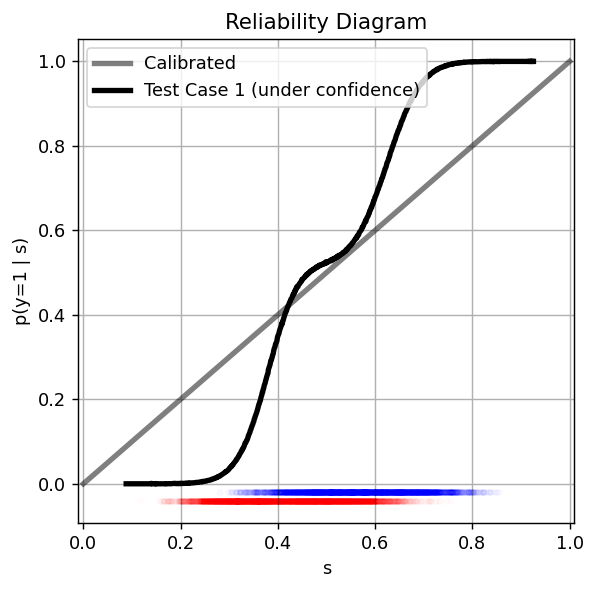

In [10]:
# draw reliability diagram
matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), numpy.linspace(0, 1, N_grid-1), 'k', linewidth=3, alpha=0.5)
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat[0, :], 'k', linewidth=3)
# matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), (p_y_hat[0, :] - 0.5) * 0.5 + 0.5, 'c', linewidth=3)
matplotlib.pyplot.plot(s_sample[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s_sample[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('p(y=1 | s)')
matplotlib.pyplot.title('Reliability Diagram')
matplotlib.pyplot.legend(['Calibrated', 'Test Case 1 (under confidence)'])
matplotlib.pyplot.xlim([-0.01, 1.01])
matplotlib.pyplot.grid()
matplotlib.pyplot.savefig('./figures/test_case_1')